## Импорты и настройки

In [ ]:
import findspark

findspark.init()

In [76]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import (
    col,
    count,
    current_date,
    when,
    isnull,
    to_timestamp,
    min,
    max,
    mean,
    sum as spark_sum,
    avg,
    stddev,
    approx_count_distinct,
    unix_timestamp,
    date_format,
    hour,
)
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
hdfs_path = "/user/ubuntu/data/2022-11-04.txt"

## Сессия

In [5]:
spark = SparkSession.builder.appName("ApacheSpark").getOrCreate()

## Загрузка данных

In [6]:
df = (
    spark.read.option("header", "false")
    .option("inferSchema", "true")
    .option("comment", "#")
    .csv(hdfs_path)
    .toDF(
        "transaction_id",
        "tx_datetime",
        "customer_id",
        "terminal_id",
        "tx_amount",
        "tx_time_seconds",
        "tx_time_days",
        "tx_fraud",
        "tx_fraud_scenario",
    )
)

df.cache()

df.show(5)

+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|transaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|    1832792610|2022-11-04 14:22:18|          0|         53|    63.58|      101139738|        1170|       0|                0|
|    1832792611|2022-11-04 02:12:24|          0|         53|    92.95|      101095944|        1170|       0|                0|
|    1832792612|2022-11-04 12:49:35|          3|        205|    48.88|      101134175|        1170|       0|                0|
|    1832792613|2022-11-04 02:40:01|          5|        383|    24.69|      101097601|        1170|       0|                0|
|    1832792614|2022-11-04 08:02:05|          6|        858|    95.48|      101116925|        1170|       0|   

## Общая информация

In [7]:
df.printSchema()

root
 |-- transaction_id: integer (nullable = true)
 |-- tx_datetime: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- terminal_id: string (nullable = true)
 |-- tx_amount: double (nullable = true)
 |-- tx_time_seconds: integer (nullable = true)
 |-- tx_time_days: integer (nullable = true)
 |-- tx_fraud: integer (nullable = true)
 |-- tx_fraud_scenario: integer (nullable = true)



In [36]:
lines_count = df.count()

print(f"Количество строк: {lines_count:,}".replace(",", " "))

Количество строк: 46 998 983


### Приведение типов

In [10]:
df = df.withColumn(
    "tx_datetime", to_timestamp(col("tx_datetime"), "yyyy-MM-dd HH:mm:ss")
)

## Анализ пропущенных значений

In [11]:
null_counts = df.select(
    [count(when(isnull(c), c)).alias(c) for c in df.columns]
)

In [ ]:
print("Количество NULL значений по столбцам")
null_counts.toPandas()

=== Количество NULL значений по столбцам ===


,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
0,0,92,0,85,0,0,0,0,0


## Анализ дубликатов

### Полные дубликаты

In [ ]:
print(
    f"Количество полностью дублированных строк: {df.exceptAll(df.dropDuplicates()).count()}"
)

Количество полностью дублированных строк: 8


### Дубликаты по признаку `transaction_id`

In [ ]:
print(
    f"Количество дубликатов transaction_id: {df.groupBy('transaction_id').count().filter(col('count') > 1).count()}"
)

Количество дубликатов transaction_id: 8


## Анализ признака `tx_amount`

### Проверка отрицательных сумм транзакций

In [ ]:
print(
    f"Количество транзакций с отрицательной суммой: {df.filter(col('tx_amount') < 0).count()}"
)

Количество транзакций с отрицательной суммой: 0


### Проверка нулевых сумм транзакций

In [ ]:
print(
    f"Количество транзакций с нулевой суммой: {df.filter(col('tx_amount') == 0).count()}"
)

Количество транзакций с нулевой суммой: 936


### Статистические параметры

In [29]:
amount_stats = df.select(
    mean("tx_amount").alias("mean"),
    stddev("tx_amount").alias("stddev"),
    min("tx_amount").alias("min"),
    max("tx_amount").alias("max"),
).collect()[0]

print(f"Среднее:                {amount_stats['mean']:.2f}")
print(f"Стандартное отклонение: {amount_stats['stddev']:.2f}")
print(f"Минимум:                {amount_stats['min']:.2f}")
print(f"Максимум:               {amount_stats['max']:.2f}")

Среднее:                54.17
Стандартное отклонение: 40.94
Минимум:                0.00
Максимум:               4754.50


In [ ]:
if amount_stats["stddev"]:
    upper_bound = amount_stats["mean"] + 3 * amount_stats["stddev"]
    lower_bound = amount_stats["mean"] - 3 * amount_stats["stddev"]
    lower_bound = 0 if lower_bound < 0 else lower_bound

    outliers = df.filter(
        (col("tx_amount") > upper_bound) | (col("tx_amount") < lower_bound)
    )
    print(
        f"Количество выбросов в tx_amount (за пределами 3сигма): {outliers.count()} ({outliers.count() / lines_count:.2%})"
    )

Количество выбросов в tx_amount (за пределами 3сигма): 348141 (0.74%)


## Анализ временных меток

In [ ]:
df = df.withColumn("tx_datetime_epoch", unix_timestamp(col("tx_datetime")))

### Проверка будущих дат

In [ ]:
print(
    f"Количество транзакций с будущими датами: {df.filter(col('tx_datetime') > current_date()).count()}"
)

Количество транзакций с будущими датами: 0


### Проверка отклонения признака `tx_time_seconds`

In [ ]:
df = df.withColumn(
    "seconds_diff", col("tx_datetime_epoch") - col("tx_time_seconds")
)

In [53]:
print("Разница между tx_datetime_epoch и tx_time_seconds")
(
    df.groupBy("seconds_diff")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
    .show()
)

Разница между tx_datetime_epoch и tx_time_seconds
+------------+--------+
|seconds_diff|   count|
+------------+--------+
|  1566432000|46998891|
|        null|      92|
+------------+--------+



### Анализ признака `tx_time_days`

In [54]:
days_stats = df.select(
    min("tx_time_days").alias("min_days"),
    max("tx_time_days").alias("max_days"),
).collect()[0]

print(f"Минимальное значение : {days_stats['min_days']}")
print(f"Максимальное значение: {days_stats['max_days']}")

Минимальное значение : 1170
Максимальное значение: 1199


## Анализ категориальных переменных

### Проверка уникальных значений

In [ ]:
print("Количество уникальных значений")
tmp = dict()


for column in ["customer_id", "terminal_id", "tx_fraud", "tx_fraud_scenario"]:

    unique_count = df.select(
        approx_count_distinct(column).alias(f"unique_{column}")
    ).collect()[0][0]
    tmp[column] = [unique_count]


pd.DataFrame.from_dict(tmp)

Количество уникальных значений


,customer_id,terminal_id,tx_fraud,tx_fraud_scenario
0,939600,1034,2,4


### Проверка флагов мошенничества

In [ ]:
df.groupBy("tx_fraud").count().orderBy("tx_fraud").toPandas()

Распределение флагов мошенничества


,tx_fraud,count
0,0,45592832
1,1,1406151


In [63]:
df.groupBy("tx_fraud_scenario").count().orderBy("tx_fraud_scenario").toPandas()

,tx_fraud_scenario,count
0,0,45592832
1,1,26226
2,2,1328968
3,3,50957


### Проверка связи между `fraud` и `fraud_scenario`

In [ ]:
invalid_fraud_relation = df.filter(
    (col("tx_fraud") == 0) & (col("tx_fraud_scenario") != 0)
)
if invalid_fraud_relation.count() != 0:

    print(
        f"Количество записей, где fraud=0, а fraud_scenario не 0: {invalid_fraud_relation.count()}"
    )

### Проверка "положительности" `customer_id`

In [ ]:
print(
    f"Количество записей с отрицательным customer_id: {df.filter(col('customer_id') < 0).count()}"
)

Количество записей с отрицательным customer_id: 96


## Графики

In [ ]:
df_clean = df.filter(
    col("tx_datetime").isNotNull() & col("tx_fraud").isNotNull()
)

### Мошеннические транзакции по дням

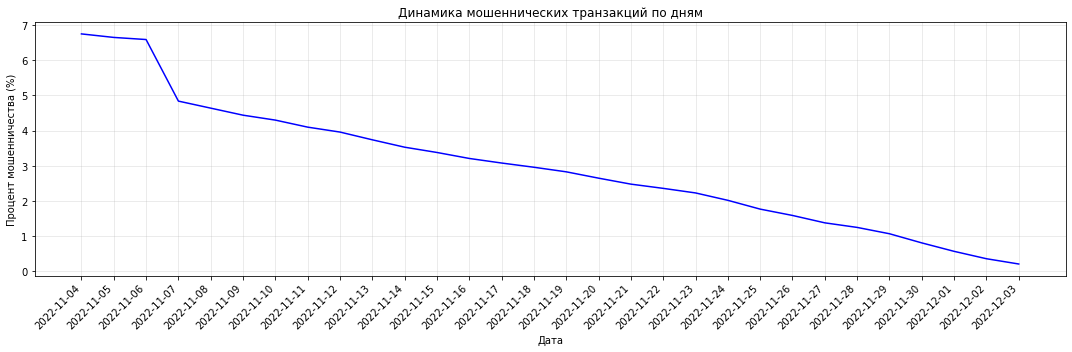

In [ ]:
fraud_by_day = (
    df_clean.groupBy(date_format("tx_datetime", "yyyy-MM-dd").alias("date"))
    .agg(
        count("*").alias("total"),
        count(when(col("tx_fraud") == 1, True)).alias("fraud"),
    )
    .orderBy("date")
)

fraud_day_pd = fraud_by_day.toPandas()
fraud_day_pd["fraud_percent"] = (
    fraud_day_pd["fraud"] / fraud_day_pd["total"] * 100
).round(2)

plt.figure(figsize=(15, 5))
plt.plot(fraud_day_pd["date"], fraud_day_pd["fraud_percent"])
plt.xlabel("Дата")
plt.ylabel("Процент мошенничества (%)")
plt.title("Динамика мошеннических транзакций по дням")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Распределение транзакций по часам

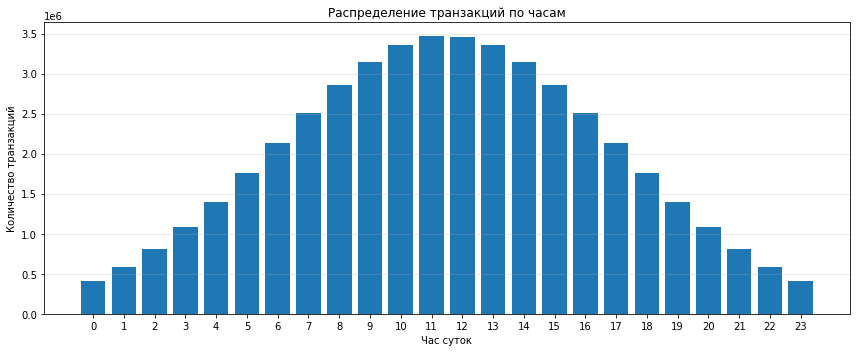

In [ ]:
hour_counts = (
    df_clean.groupBy(hour("tx_datetime").alias("hour")).count().orderBy("hour")
)
hour_pd = hour_counts.toPandas()

plt.figure(figsize=(12, 5))
plt.bar(hour_pd["hour"], hour_pd["count"])
plt.xlabel("Час суток")
plt.ylabel("Количество транзакций")
plt.title("Распределение транзакций по часам")
plt.xticks(range(0, 24))
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Pipeline очистки данных

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, stddev, mean, row_number
from pyspark.sql.window import Window


def clean_data_pipeline(input_txt: str, output_parquet: str):
    print("Инициализация сессии")
    spark = SparkSession.builder.getOrCreate()

    print("Загрузка данных")
    df = (
        spark.read.option("header", "false")
        .option("inferSchema", "true")
        .option("comment", "#")
        .csv(input_txt)
        .toDF(
            "transaction_id",
            "tx_datetime",
            "customer_id",
            "terminal_id",
            "tx_amount",
            "tx_time_seconds",
            "tx_time_days",
            "tx_fraud",
            "tx_fraud_scenario",
        )
    )

    print("Удаление NaN")
    df = df.dropna()

    print("Удаление явных дубликатов")
    df = df.dropDuplicates()

    print("Удаление дубликатов по 'transaction_id'")
    df = (
        df.withColumn(
            "rn",
            row_number().over(
                Window.partitionBy("transaction_id").orderBy("tx_datetime")
            ),
        )
        .filter(col("rn") == 1)
        .drop("rn")
    )

    print("Фильтрация 'tx_amount > 0'")
    df = df.filter(col("tx_amount") > 0)

    print("Удаление выбросов в 'tx_amount' (три сигма)")
    stats = df.select(
        mean("tx_amount").alias("m"), stddev("tx_amount").alias("s")
    ).first()
    if stats["s"]:
        lower = stats["m"] - 3 * stats["s"]
        upper = stats["m"] + 3 * stats["s"]
        df = df.filter(
            (col("tx_amount") >= lower) & (col("tx_amount") <= upper)
        )

    print("Фильтр 'customer_id > 0'")
    df = df.filter(col("customer_id") > 0)

    print("Сохранение")
    df.write.mode("overwrite").parquet(output_parquet)

    spark.stop()


clean_data_pipeline(input_txt=hdfs_path, output_parquet=hdfs_path + ".parquet")

Инициализация сессии
Загрузка данных
Удаление NaN
Удаление явных дубликатов
Удаление дубликатов по 'transaction_id'
Фильтрация 'tx_amount > 0'
Удаление выбросов в 'tx_amount' (три сигма)
Фильтр 'customer_id > 0'
Сохранение
